___
___
___
# Light GBM
___
___
___
## Exercice avec le dataset "wine"
___
___
___
A partir du dataset "Wine" (wine.csv), faire des prédictions sur la note à donner d'un vin (feature "points").

Le code est pré-implanté de la même manière que l'exemple ci-dessus.

Tâches à faire :
* explorer les données
* la cible étant la note donnée à un vin, elle sera considérée comme catégorielle
* afficher les résultats suivants : La matrice de confusion, Accuracy
* il faut sans doute convertir les résultats de *y_pred_lgbm*
* tester des hyperparamètres, sources : https://lightgbm.readthedocs.io/en/latest/Parameters.html | https://towardsdatascience.com/beginners-guide-to-the-must-know-lightgbm-hyperparameters-a0005a812702

### Import & données

In [221]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime # juste pour chronométrer
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix # roc_auc_score pour quantifier la matrice de confusion
# En résumé, le score AUC-ROC évalue la capacité d'un modèle à bien classer les exemples positifs par rapport
# aux exemples négatifs à différents seuils de probabilité, et il fournit un nombre unique pour mesurer cette performance,
# où un score plus élevé indique une meilleure performance.
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb # librairie LightGBM à installer au préalable $ pip install lightgbm

df = pd.read_csv("wine.csv")

X = df.drop(labels = ["Unnamed: 0", "points"], axis=1)
y = df[['points']]

intervales = [80, 85, 90, 95, 100, 105]
etiquettes = ['80-84', '85-89', '90-94', '95-99', '100-104']

# Utiliser pd.cut pour créer une nouvelle colonne avec les catégories
y['points'] = pd.cut(y['points'], bins=intervales, labels=etiquettes, include_lowest=True)

print('##################################################')
print("Taille du dataset :", X.shape, y.shape)
print('##################################################')
y = y['points']

##################################################
Taille du dataset : (129971, 12) (129971, 1)
##################################################


/tmp/ipykernel_94858/892481712.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['points'] = pd.cut(y['points'], bins=intervales, labels=etiquettes, include_lowest=True)


### Exploration des données

In [222]:
display(X.head(2))
print("##################################################")
print("valeurs uniques de y =>", y.unique())

,country,description,designation,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


##################################################
valeurs uniques de y => ['85-89', '80-84', '90-94', '95-99']
Categories (5, object): ['80-84' < '85-89' < '90-94' < '95-99' < '100-104']


### Nettoyage des données

In [223]:
labelencoder = LabelEncoder()

y = labelencoder.fit_transform(y)
print(y)

for column in X.columns:
    X[column] = labelencoder.fit_transform(X[column])

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

[1 1 1 ... 1 1 1]


### Split du dataset

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("Taille des jeux de données :", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Taille des jeux de données : (103976, 12) (103976,) (25995, 12) (25995,)


### **LightGBM**

In [225]:
d_train = lgb.Dataset(X_train, label=y_train)

# https://lightgbm.readthedocs.io/en/latest/Parameters.html
# sans paramètre => Accuracy with LGBM =  66.18 %
lgbm_params = {
    'objective': 'multiclass',
    'num_class': 4,
    'boosting_type': 'dart',
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
}

start=datetime.now()
clf = lgb.train(lgbm_params, d_train, 50) #50 iterations. Increase iterations for small learning rates
stop=datetime.now()
execution_time_lgbm = stop-start

#Prediction on test data
y_pred_lgbm=clf.predict(X_test)

#convert into binary values 0/1 for classification
y_pred_lgbm = [list(x).index(max(x)) for x in y_pred_lgbm]

___
### Confusion matrix
___

################################################
# LGBM execution time is:  0:00:01.599063
################################################
# Accuracy with LGBM =  65.43 %
################################################


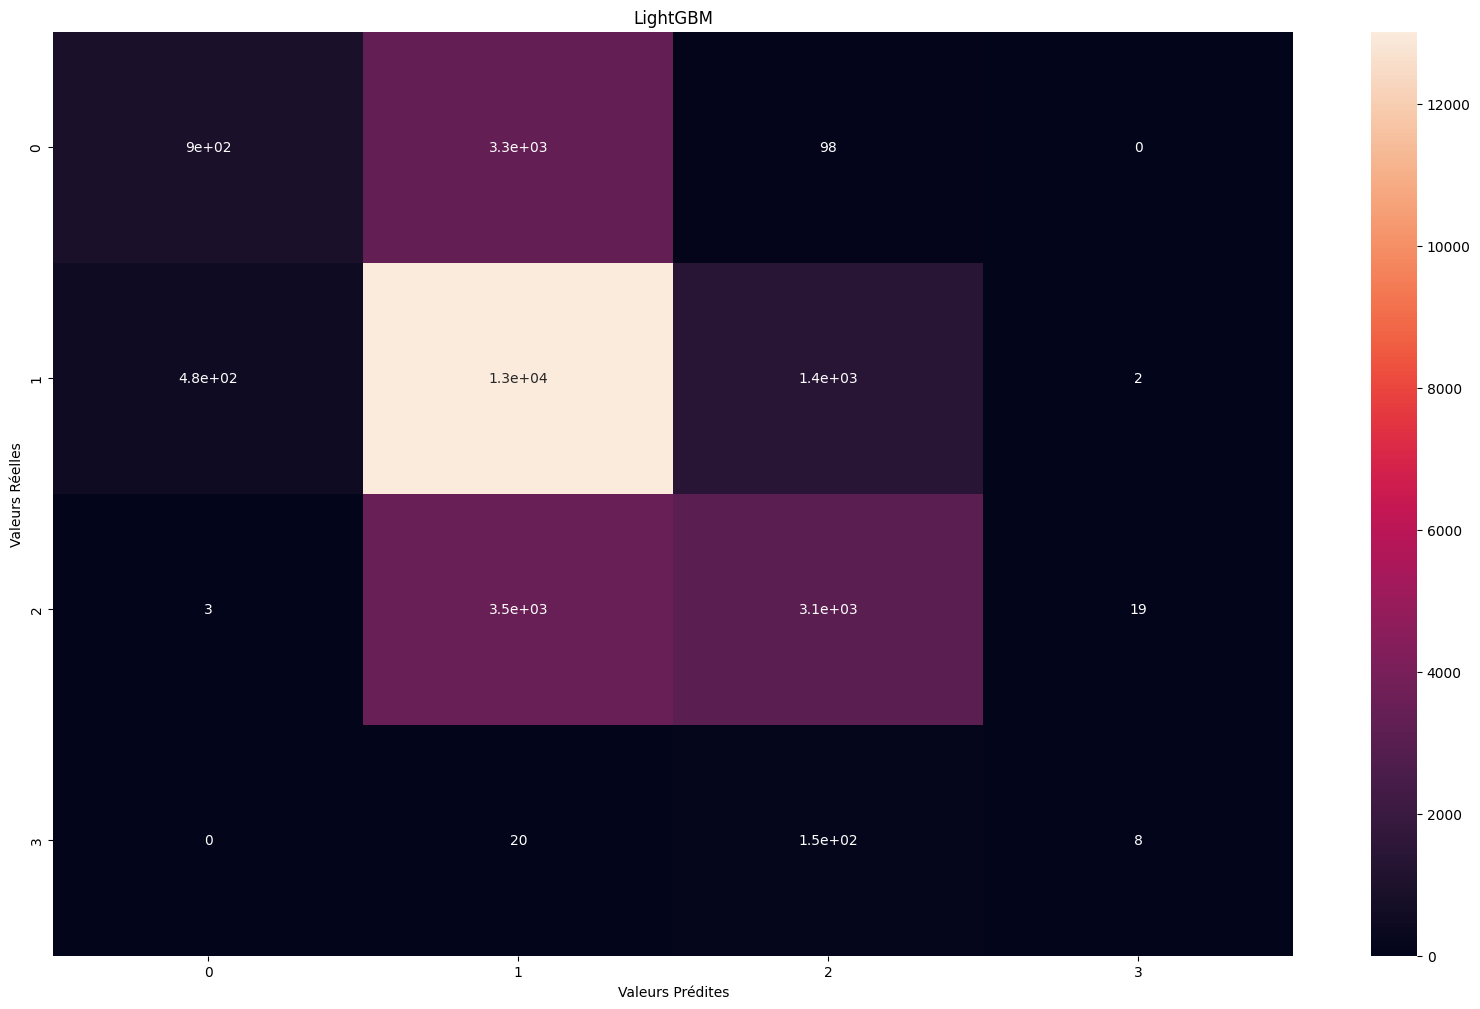

In [231]:
plt.figure(figsize=(20, 12))
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(cm_lgbm, annot=True)
plt.title("LightGBM")
plt.xlabel('Valeurs Prédites')
plt.ylabel('Valeurs Réelles')

################
#SUMMARY
print("################################################")
print("# LGBM execution time is: ", execution_time_lgbm)
print("################################################")
print ("# Accuracy with LGBM = ", round(metrics.accuracy_score(y_pred_lgbm,y_test) * 100, 2), '%')
print("################################################")